In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/Shareddrives/機器學習/AOI data") #這邊輸入欲使用的資料夾路徑
os.getcwd()

'/content/drive/Shareddrives/機器學習/AOI data'

In [3]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 4.8 MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import cv2
import seaborn as sns
import mahotas
import glob
import argparse
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

In [5]:
train = pd.read_csv("AOI_test_check.csv")
train.head()

,ID,Label
0,test_00000.png,NaN
1,test_00001.png,NaN
2,test_00002.png,NaN
3,test_00003.png,NaN
4,test_00004.png,NaN


In [6]:
data_path = "AOI_Test_Image" #路徑掛載到存放圖片的資料夾路徑

image shape: (512, 512, 3)
data type: uint8
min: 118, max: 215


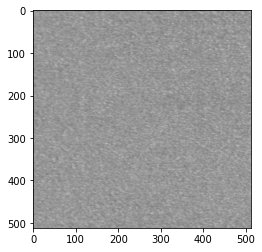

In [7]:
# 挑選一張切割前的原圖
img = cv2.imread(os.path.join(data_path, train.loc[320, "ID"]))
print(f"image shape: {img.shape}")
print(f"data type: {img.dtype}")
print(f"min: {img.min()}, max: {img.max()}")
plt.imshow(img)
plt.show()

In [8]:
# 設置切割參數
crop = []
point = [0, 128, 256, 384, 512]
for i in range(4):
  for j in range(4):
    crop.append([point[i]]+[point[i+1]]+[point[j]]+[point[j+1]])
crop

[[0, 128, 0, 128],
 [0, 128, 128, 256],
 [0, 128, 256, 384],
 [0, 128, 384, 512],
 [128, 256, 0, 128],
 [128, 256, 128, 256],
 [128, 256, 256, 384],
 [128, 256, 384, 512],
 [256, 384, 0, 128],
 [256, 384, 128, 256],
 [256, 384, 256, 384],
 [256, 384, 384, 512],
 [384, 512, 0, 128],
 [384, 512, 128, 256],
 [384, 512, 256, 384],
 [384, 512, 384, 512]]

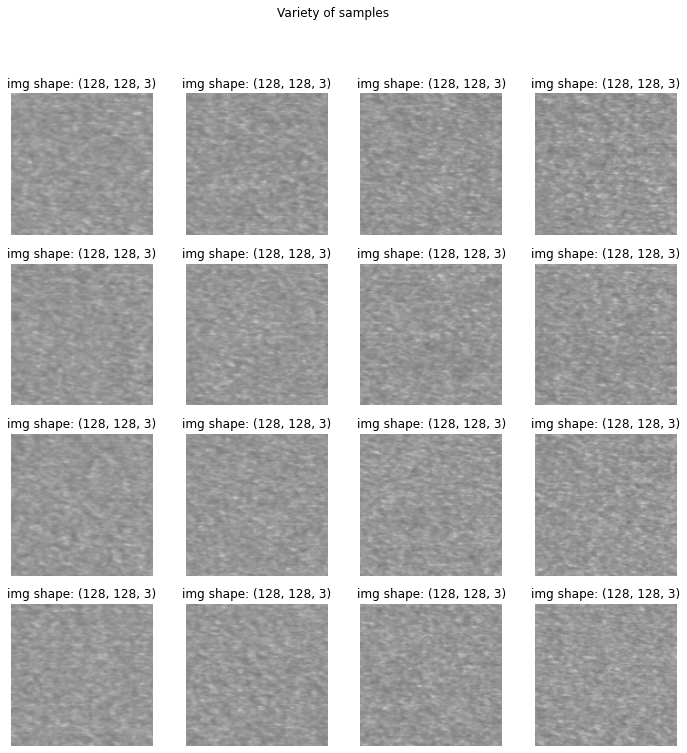

In [9]:
# 切割成4*4個子圖的效果
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread(os.path.join(data_path, train.loc[320, "ID"]))[crop[i][0]:crop[i][1], crop[i][2]:crop[i][3]]
    plt.imshow(img,cmap='gray')
    plt.axis("off")
    plt.title(f"img shape: {img.shape}")
plt.suptitle(f"Variety of samples", fontsize=12)
plt.show()

In [10]:
import statistics
a=img.reshape(-1)

In [11]:
# 將4*4個子圖的特徵合併成一個dataframe
df_hara = pd.DataFrame()
for i in range(16):
  img = cv2.imread(os.path.join(data_path, train.loc[320,"ID"]))[crop[i][0]:crop[i][1], crop[i][2]:crop[i][3]]
  image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  df_hara = df_hara.append(list(mahotas.features.haralick(image)))

df_hara

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.001983,26.066006,0.838780,80.839800,0.214077,302.177965,297.293193,6.114529,9.444794,0.000487,3.475538,-0.176393,0.916039
1,0.001364,66.875070,0.585413,80.652613,0.143086,302.144336,255.735383,6.014072,9.979498,0.000306,4.123795,-0.072531,0.726729
2,0.001396,63.874323,0.603569,80.561617,0.147608,302.141917,258.372146,6.019508,9.953189,0.000315,4.090103,-0.077433,0.742600
3,0.001315,74.946866,0.535362,80.650877,0.139564,302.144336,247.656642,5.989693,10.036194,0.000288,4.205373,-0.061575,0.686617
0,0.001788,28.354023,0.843160,90.391454,0.208698,299.217089,333.211792,6.201104,9.590636,0.000496,3.533125,-0.177769,0.919819
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.001054,97.845248,0.496520,97.169034,0.122585,301.129766,290.830888,6.109703,10.326518,0.000258,4.389308,-0.055186,0.665942
0,0.001443,39.330893,0.812816,105.059547,0.182399,304.067483,380.907294,6.290773,9.888978,0.000387,3.761252,-0.156173,0.901515
1,0.000997,103.395127,0.509003,105.290900,0.121436,304.100936,317.768471,6.171513,10.417136,0.000240,4.428070,-0.058258,0.681753
2,0.001012,99.296014,0.528605,105.321471,0.122730,304.109990,321.989871,6.179732,10.398186,0.000245,4.399566,-0.061810,0.696281


In [12]:
# 將4*4個子圖的特徵合併成一個dataframe的一個row
oneimage = list()
for i in range(64):
  oneimage = oneimage + list(df_hara.iloc[i])

df_oneimage = pd.DataFrame([oneimage])
df_oneimage

,0,1,2,3,4,5,6,7,8,9,...,822,823,824,825,826,827,828,829,830,831
0,0.001983,26.066006,0.83878,80.8398,0.214077,302.177965,297.293193,6.114529,9.444794,0.000487,...,105.29235,0.112989,304.0992,303.003117,6.138672,10.47855,0.000222,4.52207,-0.046812,0.62837


In [13]:
# 計算test圖片的4*4個子圖之特徵之特徵m,v,s,k

df_crop44 = pd.DataFrame()

test = [320,321,322]

#for i in range(len(train)):
for j in test:

  # 將4*4個子圖的特徵合併成一個dataframe
  df_hara = pd.DataFrame()
  for i in range(16):
    img = cv2.imread(os.path.join(data_path, train.loc[j,"ID"]))[crop[i][0]:crop[i][1], crop[i][2]:crop[i][3]]
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    df_hara = df_hara.append(list(mahotas.features.haralick(image)))

  # df_hara的變成一個row
  oneimage = list()
  for i in range(64):
    oneimage = oneimage + list(df_hara.iloc[i])
  df_oneimage = pd.DataFrame([oneimage])

  # 一張照片的13*4個特徵為df_crop44的的一個row
  df_crop44 = pd.concat([df_crop44, df_oneimage])

df_crop44

,0,1,2,3,4,5,6,7,8,9,...,822,823,824,825,826,827,828,829,830,831
0,0.001983,26.066006,0.838780,80.839800,0.214077,302.177965,297.293193,6.114529,9.444794,0.000487,...,105.292350,0.112989,304.099200,303.003117,6.138672,10.478550,0.000222,4.522070,-0.046812,0.628370
0,0.000572,136.858883,0.710539,236.403166,0.104440,351.688976,808.753781,6.824794,11.212727,0.000173,...,186.458342,0.091243,352.403931,563.928786,6.581329,11.180135,0.000149,4.822902,-0.064377,0.724320
0,0.004824,3.196174,0.983379,96.147133,0.482739,292.475455,381.392360,6.313629,8.170709,0.001447,...,61.792220,0.366669,290.531899,240.139614,5.979582,8.399899,0.001004,2.606740,-0.322024,0.979902


In [14]:
# 計算所有圖片的4*4個子圖之特徵
df_crop44 = pd.DataFrame()

for j in range(len(train)):

  # 將4*4個子圖的特徵合併成一個dataframe
  df_hara = pd.DataFrame()
  for i in range(16):
    img = cv2.imread(os.path.join(data_path, train.loc[j,"ID"]))[crop[i][0]:crop[i][1], crop[i][2]:crop[i][3]]
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    df_hara = df_hara.append(list(mahotas.features.haralick(image)))

  # df_hara的變成一個row
  oneimage = list()
  for i in range(64):
    oneimage = oneimage + list(df_hara.iloc[i])
  df_oneimage = pd.DataFrame([oneimage])

  # 一張照片的13*4個特徵為df_crop44的的一個row
  df_crop44 = pd.concat([df_crop44, df_oneimage])

df_crop44

,0,1,2,3,4,5,6,7,8,9,...,822,823,824,825,826,827,828,829,830,831
0,0.004046,1.485913,0.997698,322.718960,0.583388,412.260642,1289.389927,7.154648,8.438985,0.001393,...,412.357040,0.576667,404.349061,1647.617632,7.217675,8.634174,0.001321,1.783591,-0.613765,0.999761
0,0.000593,210.031804,0.377573,168.720085,0.085912,334.301243,464.848537,6.438486,11.151394,0.000143,...,252.036653,0.054256,334.481493,476.545274,6.462471,11.770906,0.000081,5.584231,-0.032860,0.570210
0,0.000497,222.702018,0.480231,214.231578,0.083620,301.556471,634.224296,6.662365,11.395198,0.000146,...,185.628205,0.064978,308.378015,401.119489,6.345651,11.387255,0.000114,5.270809,-0.027189,0.519030
0,0.003977,3.997478,0.982346,113.216627,0.444526,327.152498,448.869030,6.417916,8.436841,0.001154,...,111.306220,0.306745,324.593217,434.533083,6.380900,9.091028,0.000733,2.877256,-0.317857,0.983766
0,0.002771,17.523376,0.845636,56.760084,0.251562,291.901944,209.516960,5.884731,8.958416,0.000665,...,81.047617,0.165163,307.235290,273.264187,6.060819,9.838631,0.000351,3.935757,-0.101294,0.806213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000552,35.886073,0.974526,704.373573,0.195544,385.551304,2781.608219,7.707359,11.182423,0.000337,...,611.875292,0.151271,377.165664,2382.528324,7.607223,11.468780,0.000253,4.108776,-0.269513,0.985856
0,0.000935,36.866757,0.953233,394.150349,0.187657,419.358022,1539.734640,7.056445,10.592351,0.000335,...,50.051369,0.198611,310.040052,168.433513,5.722835,9.211107,0.000481,3.612904,-0.100723,0.789651
0,0.000228,290.068344,0.815831,787.504190,0.076943,375.356976,2859.948417,7.724182,12.501537,0.000112,...,824.160485,0.030568,358.535557,1656.584900,7.373237,13.218707,0.000039,6.389745,-0.065544,0.769222
0,0.000757,121.157234,0.599222,151.152512,0.109086,291.601378,483.452813,6.456367,10.799277,0.000204,...,231.584565,0.058171,297.701593,444.718505,6.412978,11.652800,0.000094,5.513951,-0.032040,0.561920


In [15]:
# column name
col_names = []
for i in range(832):
  col_names.append("X"+str(i))
df_crop44.columns = col_names
df_crop44

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X822,X823,X824,X825,X826,X827,X828,X829,X830,X831
0,0.004046,1.485913,0.997698,322.718960,0.583388,412.260642,1289.389927,7.154648,8.438985,0.001393,...,412.357040,0.576667,404.349061,1647.617632,7.217675,8.634174,0.001321,1.783591,-0.613765,0.999761
0,0.000593,210.031804,0.377573,168.720085,0.085912,334.301243,464.848537,6.438486,11.151394,0.000143,...,252.036653,0.054256,334.481493,476.545274,6.462471,11.770906,0.000081,5.584231,-0.032860,0.570210
0,0.000497,222.702018,0.480231,214.231578,0.083620,301.556471,634.224296,6.662365,11.395198,0.000146,...,185.628205,0.064978,308.378015,401.119489,6.345651,11.387255,0.000114,5.270809,-0.027189,0.519030
0,0.003977,3.997478,0.982346,113.216627,0.444526,327.152498,448.869030,6.417916,8.436841,0.001154,...,111.306220,0.306745,324.593217,434.533083,6.380900,9.091028,0.000733,2.877256,-0.317857,0.983766
0,0.002771,17.523376,0.845636,56.760084,0.251562,291.901944,209.516960,5.884731,8.958416,0.000665,...,81.047617,0.165163,307.235290,273.264187,6.060819,9.838631,0.000351,3.935757,-0.101294,0.806213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000552,35.886073,0.974526,704.373573,0.195544,385.551304,2781.608219,7.707359,11.182423,0.000337,...,611.875292,0.151271,377.165664,2382.528324,7.607223,11.468780,0.000253,4.108776,-0.269513,0.985856
0,0.000935,36.866757,0.953233,394.150349,0.187657,419.358022,1539.734640,7.056445,10.592351,0.000335,...,50.051369,0.198611,310.040052,168.433513,5.722835,9.211107,0.000481,3.612904,-0.100723,0.789651
0,0.000228,290.068344,0.815831,787.504190,0.076943,375.356976,2859.948417,7.724182,12.501537,0.000112,...,824.160485,0.030568,358.535557,1656.584900,7.373237,13.218707,0.000039,6.389745,-0.065544,0.769222
0,0.000757,121.157234,0.599222,151.152512,0.109086,291.601378,483.452813,6.456367,10.799277,0.000204,...,231.584565,0.058171,297.701593,444.718505,6.412978,11.652800,0.000094,5.513951,-0.032040,0.561920


In [16]:
# csv output
df_crop44_output = df_crop44.copy()

# df_crop44_output.index = train["Label"].index
# df_crop44_output = pd.concat([df_crop44_output,train["Label"]],axis = 1)
df_crop44_output

df_crop44_output.to_csv("/content/drive/Shareddrives/機器學習/第三次討論/crop csv/test_crop4x4all.csv")